# Deep Learning Notebook of project Building-Perceptron

## Introduction (must be done in english)

## Imports

In [99]:
# !pip install --upgrade pip
# !pip install statsmodels

In [100]:
# run pipreqs --force in notebook for imports outside of

In [101]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import statsmodels.api as sm


import shap
shap.initjs()


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [102]:

orange = "#FFA500"
purple = "#800080"
grey = "#808080"

custom_palette = ["#FFA500", "#FF8C00", "#FF5500", "#FF2200", "#800040", "#400080", "#800080", "#808080", "#808080"]

custom_palette_f5 = [
    purple   ,  # purple
    '#3B528B',  # Blue
    orange   ,  #orange
    '#21918C',  # Green
    # '#5DC863',  # Yellow-Green
    grey     ,  #grey
    # '#FDE725'   # Yellow
]

viridis_colors = [
    purple   ,  # Purple
    '#3B528B',  # Blue
    '#21918C',  # Green
    '#5DC863',  # Yellow-Green
    '#FDE725'   # Yellow
]

sns.set_palette(custom_palette)


## Data Exploration

### Loading Data

In [103]:
original_df = pd.read_csv("data/bcw_data.csv")
# shuffling df to prepare for eventual data reduction from balancing target
df = original_df.sample(frac=1).reset_index(drop=True)


### Exploratory analysis

#### General checks

In [104]:
df.shape

(569, 33)

In [105]:
df.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,88411702,B,13.75,23.77,88.54,590.0,0.08043,0.06807,0.04697,0.02344,...,26.34,98.0,706.0,0.09368,0.1442,0.1359,0.06106,0.2663,0.06321,NaN
1,859717,M,17.20,24.52,114.20,929.4,0.10710,0.18300,0.16920,0.07944,...,33.82,151.6,1681.0,0.15850,0.7394,0.6566,0.18990,0.3313,0.13390,NaN


In [106]:
df.duplicated().sum()

0

In [107]:
df.dtypes.value_counts().index

Index([float64, int64, object], dtype='object')

In [108]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [109]:
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [110]:
df["Unnamed: 32"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
564   NaN
565   NaN
566   NaN
567   NaN
568   NaN
Name: Unnamed: 32, Length: 569, dtype: float64

In [111]:
df.drop(columns = ["Unnamed: 32"], inplace=True)

In [112]:
percentage_missing = df.isnull().sum().sort_values(ascending = False)/df.shape[0]*100
print(f"{percentage_missing[percentage_missing<30].count()} beneficial features")
percentage_missing

32 beneficial features


id                         0.0
diagnosis                  0.0
symmetry_worst             0.0
concave points_worst       0.0
concavity_worst            0.0
compactness_worst          0.0
smoothness_worst           0.0
area_worst                 0.0
perimeter_worst            0.0
texture_worst              0.0
radius_worst               0.0
fractal_dimension_se       0.0
symmetry_se                0.0
concave points_se          0.0
concavity_se               0.0
compactness_se             0.0
smoothness_se              0.0
area_se                    0.0
perimeter_se               0.0
texture_se                 0.0
radius_se                  0.0
fractal_dimension_mean     0.0
symmetry_mean              0.0
concave points_mean        0.0
concavity_mean             0.0
compactness_mean           0.0
smoothness_mean            0.0
area_mean                  0.0
perimeter_mean             0.0
texture_mean               0.0
radius_mean                0.0
fractal_dimension_worst    0.0
dtype: f

#### Objects

In [113]:
df.select_dtypes(include=['object']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   diagnosis  569 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


In [114]:
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

#### Int64

In [115]:
df.select_dtypes(include=['int64']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      569 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB


#### Float64

In [116]:
df.select_dtypes(include=['float64']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

### Data Cleaning

#### Target 

In [117]:
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == "M" else 0)

In [118]:
df.diagnosis.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

##### Balancing the target

In [122]:
df[df.diagnosis == 1].shape[0]

212

In [127]:
# Separate the two classes
class_1 = df[df.diagnosis == 1]
class_0 = df[df.diagnosis == 0]

# Randomly sample class_0 to match the number of samples in class_1
class_0_balanced = class_0.sample(n=class_1.shape[0], random_state=42)  # Set random_state for reproducibility

# Concatenate the balanced classes
balanced_df = pd.concat([class_1, class_0_balanced], ignore_index=True)
print(balanced_df.diagnosis.value_counts())

diagnosis
1    212
0    212
Name: count, dtype: int64


## Isolating changes made for future pipeline

In [ ]:
df = original_df.copy()
# classify target, Benign as 0, Malignant as 1
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == "M" else 0)

# dropping useless cols
df.drop(columns = ["id", "Unnamed: 32"], inplace=True)

In [128]:
# don't forget to do the balancing and every other operations after it again.

## Preparing for Deep Learning

### Feature Selection / Dimensionality Reduction

### Shap Feature Importance

In [ ]:
X = df.drop("diagnosis", axis=1) # Independent variables
y = df.diagnosis # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       111
           1       0.90      0.95      0.93        60

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



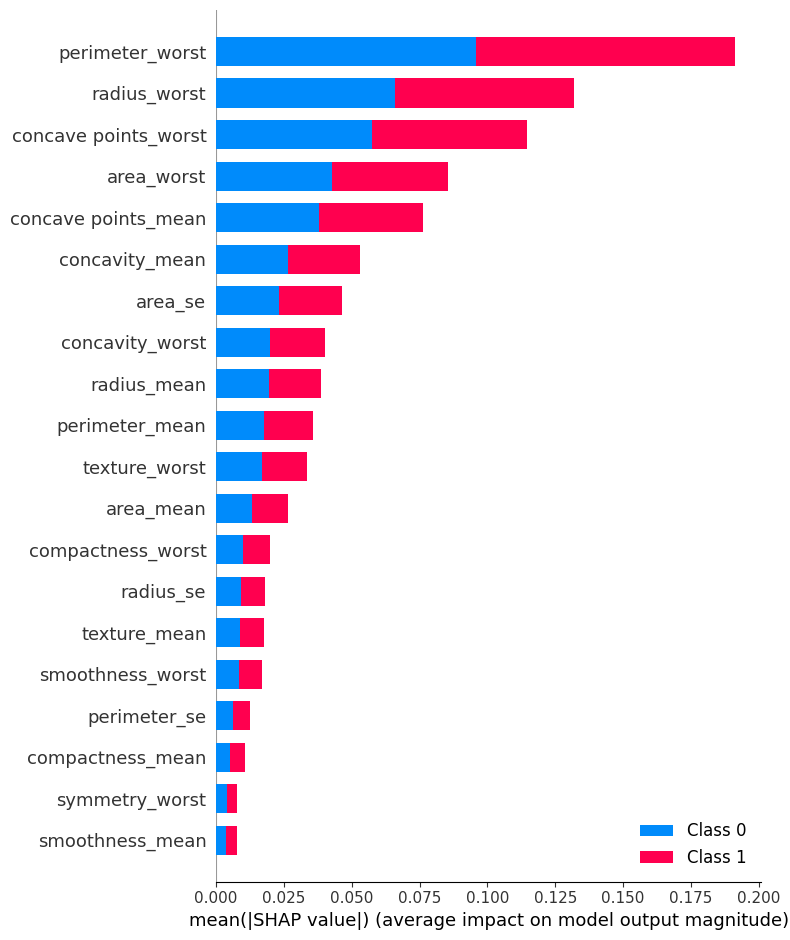

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

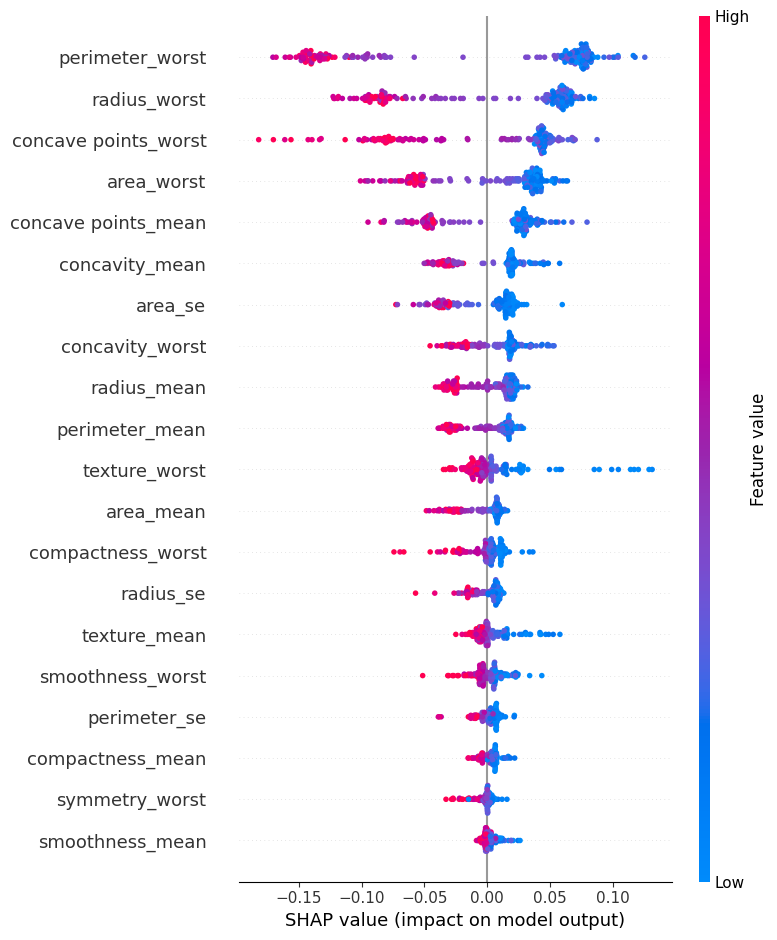

In [ ]:
shap.summary_plot(shap_values[0], X_test)

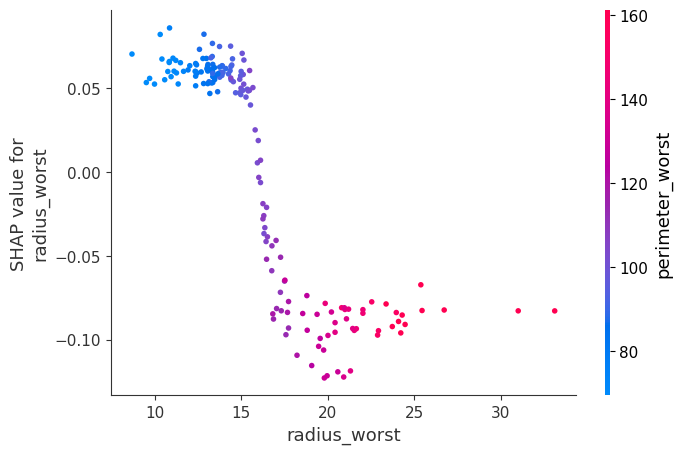

In [ ]:
shap.dependence_plot("radius_worst", shap_values[0], X_test,interaction_index="perimeter_worst")

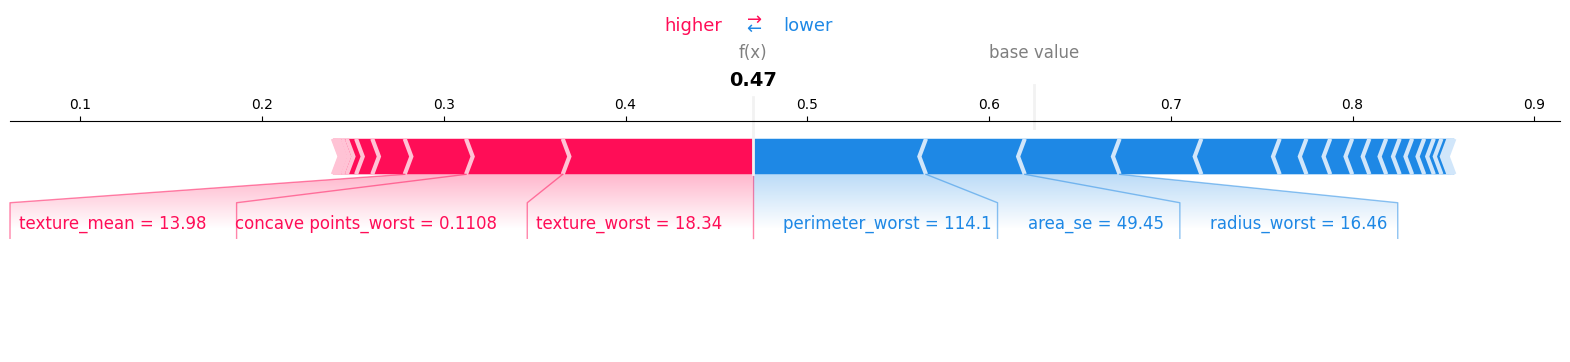

In [ ]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)

In [ ]:
# shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], X_test.iloc[6, :],matplotlib = True)

In [ ]:
# impact_scores = np.abs(shap_values[1]).sum(axis=1)
# most_impactful_index = np.argmax(impact_scores)  # Gives the index of the most impactful sample
# impact_scores

In [ ]:
# Sum of absolute SHAP values across all samples for each feature
feature_impact_scores = np.abs(shap_values[1]).sum(axis=0)

# Creating a dictionary with feature names and their associated impact scores
impact_scores_dict = dict(zip(X_test.columns, feature_impact_scores))

# Sorting the dictionary by values (impact scores) in descending order
sorted_impact_scores_dict = dict(sorted(impact_scores_dict.items(), key=lambda item: item[1], reverse=True))

# Printing the sorted impact scores
print(sorted_impact_scores_dict)


{'perimeter_worst': 16.36646366787941, 'radius_worst': 11.289845914911233, 'concave points_worst': 9.800312483430957, 'area_worst': 7.297964583003406, 'concave points_mean': 6.514240253134477, 'concavity_mean': 4.528128765310412, 'area_se': 3.974932881326925, 'concavity_worst': 3.426473205657487, 'radius_mean': 3.314306657063023, 'perimeter_mean': 3.049326452182134, 'texture_worst': 2.8636559807183293, 'area_mean': 2.2697305287214298, 'compactness_worst': 1.7025048582607543, 'radius_se': 1.5485863884822884, 'texture_mean': 1.5124986921018848, 'smoothness_worst': 1.4373348376326627, 'perimeter_se': 1.0569903068602962, 'compactness_mean': 0.907581813297264, 'symmetry_worst': 0.6736877801195243, 'smoothness_mean': 0.652984754262989, 'id': 0.5028430793407693, 'texture_se': 0.40132863994618606, 'fractal_dimension_mean': 0.3514770030243398, 'symmetry_mean': 0.34769455408353983, 'concave points_se': 0.2720478221355493, 'fractal_dimension_worst': 0.2613387054421362, 'fractal_dimension_se': 0.2

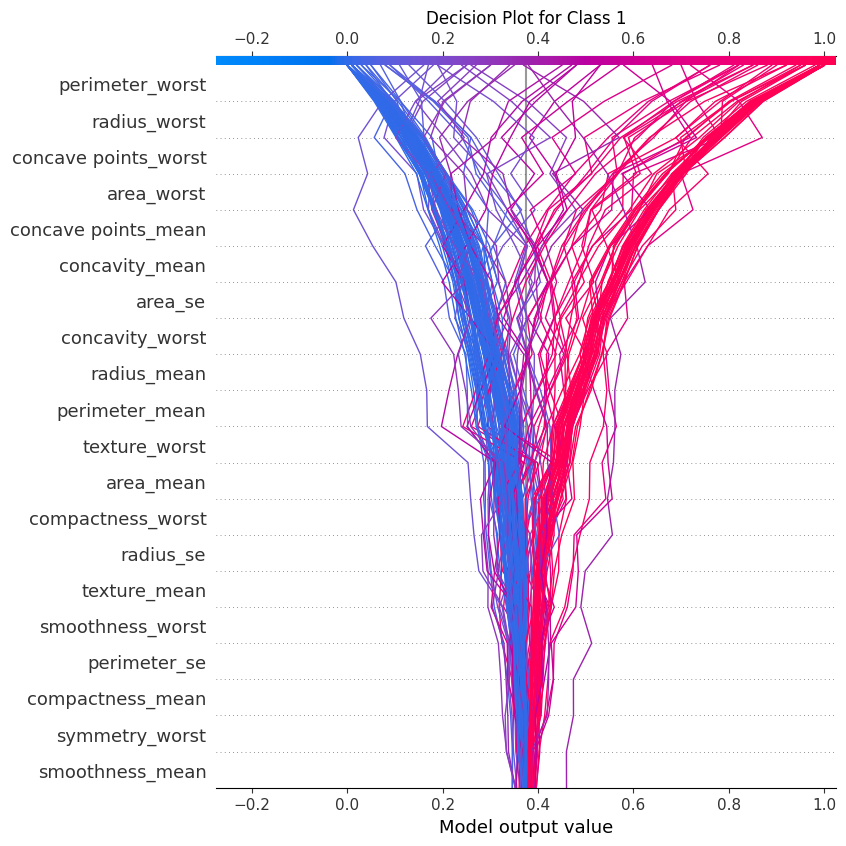

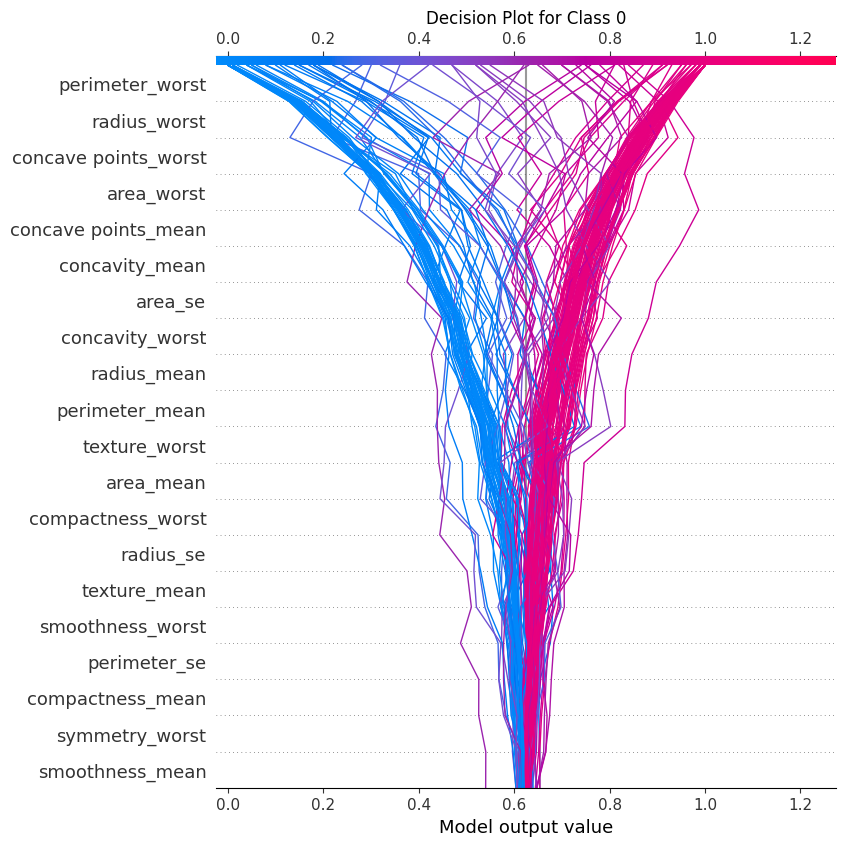

In [ ]:
# Decision plot for class 1
plt.title('Decision Plot for Class 1')
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

# Decision plot for class 0
plt.title('Decision Plot for Class 0')
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.columns)

plt.show()


#### Boruta

### Preprocessing

### Choosing Metrics

In [ ]:
# On va justifier le choix des différentes métriques qu'on va utiliser pour le projet (c'est spécifié plusieurs)

## Modelisation

### Importing the ClassPerceptron .py script

In [ ]:
# from **** import Laclass

# On peut s'inspirer du test unitaire pour voir le fonctionnement.

### Comparing with a very basic Deep Learning model

In [ ]:
# Sigmoid machin machin relou

## Evaluating the model results

## Conclusion

``Concluez sur l’efficacité d’un Perceptron sur ce type de problématique
puis, proposez des solutions sans les implémenter.``

Je conclute tu conclute

petit passage comme quoi notre perceptron est nul et c'est en explorant d'autres stratégies comme le backtracking qu'on attendra de très bon résultat